# Real time demo - trigger word detection

**"Activate"** is the trigger word trained for the model.
For alternative trigger word, you need to re-train the model to recognize it. More detail refer to [Trigger word detection - v1.ipynb](./Trigger word detection - v1.ipynb)

In [1]:
import numpy as np
import time
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
from td_utils import *
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
# To generate wav file from np array.
from scipy.io.wavfile import write
%matplotlib inline

In [2]:
# Use 1101 for 2sec input audio
Tx = 5511 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram

In [3]:
# Use 272 for 2sec input audio
Ty = 1375# The number of time steps in the output of our model

## Build the model

In [4]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam

c:\users\hasee\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
# GRADED FUNCTION: model

def model(input_shape):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
    
    ### START CODE HERE ###
    
    # Step 1: CONV layer (≈4 lines)
    X = Conv1D(filters=196, kernel_size=15, strides=4)(X_input)                                 # CONV1D
    X = BatchNormalization()(X)                                 # Batch normalization
    X = Activation('relu')(X)                                 # ReLu activation
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)

    # Step 2: First GRU Layer (≈4 lines)
    X = GRU(units=128, return_sequences=True)(X)                                 # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    X = BatchNormalization()(X)                                 # Batch normalization
    
    # Step 3: Second GRU Layer (≈4 lines)
    X = GRU(units=128, return_sequences=True)(X)                                 # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    X = BatchNormalization()(X)                                 # Batch normalization
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    
    # Step 4: Time-distributed dense layer (≈1 line)
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) # time distributed  (sigmoid)

    ### END CODE HERE ###

    model = Model(inputs = X_input, outputs = X)
    
    return model  

In [6]:
model = model(input_shape = (Tx, n_freq))
# model.summary()

In [7]:
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

## Load a pre-train model

In [8]:
model = load_model('./models/tr_model.h5')

### Detect trigger word functions

In [9]:
def detect_triggerword_spectrum(x):
    """
    Function to predict the location of the trigger word.
    
    Argument:
    x -- spectrum of shape (freqs, Tx)
    i.e. (Number of frequencies, The number time steps)

    Returns:
    predictions -- flattened numpy array to shape (number of output time steps)
    """
    # the spectogram outputs  and we want (Tx, freqs) to input into the model
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    return predictions.reshape(-1)

def has_new_triggerword(predictions, chunk_duration, feed_duration, threshold=0.5):
    """
    Function to detect new trigger word in the latest chunk of input audio.
    It is looking for the rising edge of the predictions data belongs to the
    last/latest chunk.
    
    Argument:
    predictions -- predicted labels from model
    chunk_duration -- time in second of a chunk
    feed_duration -- time in second of the input to model
    threshold -- threshold for probability above a certain to be considered positive

    Returns:
    True if new trigger word detected in the latest chunk
    """
    predictions = predictions > threshold
    chunk_predictions_samples = int(len(predictions) * chunk_duration / feed_duration)
    chunk_predictions = predictions[-chunk_predictions_samples:]
    level = chunk_predictions[0]
    for pred in chunk_predictions:
        if pred > level:
            return True
        else:
            level = pred
    return False
    
    

# Record audio stream from mic

In [10]:
chunk_duration = 0.5 # Each read length in seconds from mic.
fs = 44100 # sampling rate for mic
chunk_samples = int(fs * chunk_duration) # Each read length in number of samples.

# Each model input data duration in seconds, need to be an integer numbers of chunk_duration
feed_duration = 10
feed_samples = int(fs * feed_duration)

assert feed_duration/chunk_duration == int(feed_duration/chunk_duration)

In [11]:
def get_spectrogram(data):
    """
    Function to compute a spectrogram.
    
    Argument:
    predictions -- one channel / dual channel audio data as numpy array

    Returns:
    pxx -- spectrogram, 2-D array, columns are the periodograms of successive segments.
    """
    nfft = 200 # Length of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, _, _ = mlab.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, _, _ = mlab.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx

In [12]:
def plt_spectrogram(data):
    """
    Function to compute and plot a spectrogram.
    
    Argument:
    predictions -- one channel / dual channel audio data as numpy array

    Returns:
    pxx -- spectrogram, 2-D array, columns are the periodograms of successive segments.
    """
    nfft = 200 # Length of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, _, _, _ = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, _, _, _ = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx

### Audio stream

In [13]:
def get_audio_input_stream(callback):
    stream = pyaudio.PyAudio().open(
        format=pyaudio.paInt16,
        channels=1,
        rate=fs,
        input=True,
        frames_per_buffer=chunk_samples,
        input_device_index=0,
        stream_callback=callback)
    return stream

In [19]:
import pyaudio
from queue import Queue
from threading import Thread
import sys
import time


# Queue to communiate between the audio callback and main thread
q = Queue()

run = True

silence_threshold = 100

# Run the demo for a timeout seconds
timeout = time.time() + 0.5*60  # 0.5 minutes from now

# Data buffer for the input wavform
data = np.zeros(feed_samples, dtype='int16')

def callback(in_data, frame_count, time_info, status):
    global run, timeout, data, silence_threshold    
    if time.time() > timeout:
        run = False        
    data0 = np.frombuffer(in_data, dtype='int16')
    if np.abs(data0).mean() < silence_threshold:
        sys.stdout.write('-')
        return (in_data, pyaudio.paContinue)
    else:
        sys.stdout.write('.')
    data = np.append(data,data0)    
    if len(data) > feed_samples:
        data = data[-feed_samples:]
        # Process data async by sending a queue.
        q.put(data)
    return (in_data, pyaudio.paContinue)

stream = get_audio_input_stream(callback)
stream.start_stream()


try:
    while run:
        data = q.get()
        spectrum = get_spectrogram(data)
        preds = detect_triggerword_spectrum(spectrum)
        new_trigger = has_new_triggerword(preds, chunk_duration, feed_duration)
        if new_trigger:
            sys.stdout.write('1')
except (KeyboardInterrupt, SystemExit):
    stream.stop_stream()
    stream.close()
    timeout = time.time()
    run = False
        
stream.stop_stream()
stream.close()

-..----------------------------------.----------------------------------------------------------------------.

In [20]:
stream.stop_stream()
stream.close()

## Print the mean magnitude for each chunk of audio data
You can play around it to find a suitable `silence_threshold` for the previous demo.

In [14]:
import time
import pyaudio
import numpy as np
data_c = None


def callback(in_data, frame_count, time_info, status):
    global data_c
    data_c = np.frombuffer(in_data, dtype='int16')
    print(np.abs(data_c).mean())
    return (in_data, pyaudio.paContinue)

stream = pyaudio.PyAudio().open(
    format=pyaudio.paInt16,
    channels=1,
    rate=fs,
    input=True,
    frames_per_buffer=chunk_samples,
    input_device_index=0,
    stream_callback=callback)
stream.start_stream()
time.sleep(5.1)
stream.stop_stream()
stream.close()

63.58625850340136
133.60934240362812
131.91519274376418
73.27936507936508
49.34848072562358
52.11369614512471
54.10943310657596
50.06793650793651
51.05619047619047
52.82884353741497


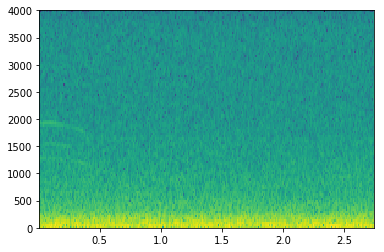

In [15]:
pxx = plt_spectrogram(data_c)

In [ ]:
write('./demo/test.wav', 44100, data_c)

In [ ]:
IPython.display.Audio("./demo/test.wav")